# Tensorflow/Keras/GPU for Chinese MNIST Prediction

As part of my learning journey, I made this project to predict the Chinese digits. So do not take it all as a serious reference 😅

I still have not learned about convolutional (Conv2D) layers, that's why I dont use them in my model.
However, I hope it is still helpful for you, specially for people starting using Tensorflow as well as I am.

* Dataset is available at [Kaggle](https://www.kaggle.com/datasets/fedesoriano/chinese-mnist-digit-recognizer)

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly as plotly
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly.express as px
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


# Load the data & vizualize it

In [2]:
df = pd.read_csv("../chineseMNIST.csv")

Let's check if the data is loaded correctly by looking at the first 5 rows of the dataframe

In [3]:
df.head()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_4088,pixel_4089,pixel_4090,pixel_4091,pixel_4092,pixel_4093,pixel_4094,pixel_4095,label,character
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,九
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,九
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,九
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,九
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,九


In [4]:
df.shape

(15000, 4098)

We can see that the last 2 columns are the label and the chinese character

The Chinese characters are the following:

* 零 - for 0
* 一 - for 1
* 二 - for 2
* 三 - for 3
* 四 - for 4
* 五 - for 5
* 六 - for 6
* 七 - for 7
* 八 - for 8
* 九 - for 9
* 十 - for 10
* 百 - for 100
* 千 - for 1000
* 万 - for 10 thousands
* 亿 - for 100 millions

Let's split the dataframe

In [5]:
# Label data frame
df_label = df["label"]

# Images dataframe (we need to drop the las 2 columns)
df_images = df.drop(["label", "character"], axis=1)

# Check the df_images shape
df_images.shape

(15000, 4096)

So we have 15000 images with 64x64 size (64*64=4096).

Let's print some data

In [6]:
print(f"Characters: {df.character.nunique()}: {list(df.character.unique())}")
print(f"Numbers: {df.label.nunique()}: {list(df.label.unique())}")

Characters: 15: ['九', '十', '百', '千', '万', '亿', '零', '一', '二', '三', '四', '五', '六', '七', '八']
Numbers: 15: [9, 10, 100, 1000, 10000, 100000000, 0, 1, 2, 3, 4, 5, 6, 7, 8]


In [7]:
# Using plotly express we will plot the count of each character from the df_label with different colors
fig = px.histogram(df, x="character", color="label")
fig.update_layout(bargap=0.2)
fig.show()


As we can see we have 1000 images of each character (15 characters * 1000 = 15000 images)

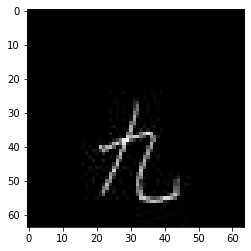

In [8]:
# Print one image to get a better sense of these examples.
plt.imshow(df_images.iloc[0].values.reshape(64,64), cmap='gray');


# Normalize the data and one-hot encode the labels

We perform a grayscale normalization to reduce the effect of illumination's differences.

Moreover the CNN converg faster on [0..1] data than on [0..255].

In [9]:
# We have images as data so to normalize let divide each pixel by 255
df_images_norm = df_images / 255.0


In [10]:
# Now lets reshape it
df_images_norm = df_images_norm.values.reshape(-1, 64, 64, 1)


We reshape all data to 64x64x1 3D matrices.

Keras requires an extra dimension in the end which correspond to channels. MNIST images are gray scaled so it use only one channel. For RGB images, there is 3 channels, we would have reshaped to 64x64x3 3D matrices.

In [11]:
# Print the shape to check if it is correct
df_images_norm.shape

(15000, 64, 64, 1)

Labels are numbers from 0 to 9 then 100, 1000, 10000, 100000000. 
We need to encode these lables to one hot vectors.
But first we'll replace the labels with large numbers to small numbers so it is easier to one-hot encode it.

* 100 -> 11
* 1000 -> 12
* 10000 -> 13
* 100000000 -> 14

In [12]:
# Encode labels to one hot vectors
# First lets replace the big numbers with smaller ones so it will be easier to encode
df_label.replace(100, 11, inplace=True)
df_label.replace(1000, 12, inplace=True)
df_label.replace(10000, 13, inplace=True)
df_label.replace(100000000, 14, inplace=True)

# Now we can encode the labels
from keras.utils.np_utils import to_categorical
df_label_onehot = to_categorical(df_label, num_classes = 15)

# Split the data into training, test and validation sets

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_images_norm, df_label_onehot, test_size=0.2, random_state=42) # Ratio is 80:20
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.15, random_state=42) # Ratio is 85:15

In [14]:
# Check the shape of the train, test and validation sets
print(f"Training data size is {X_train.shape}")
print(f"Testing data size is {X_test.shape}")
print(f"Validation data size is {X_val.shape}")

Training data size is (12000, 64, 64, 1)
Testing data size is (450, 64, 64, 1)
Validation data size is (2550, 64, 64, 1)


# Create the model

## Finding the optimal learning rate

First we'll make smaller model to get the optimal learning rate.

In [15]:
tf.random.set_seed(42)

# Create the model
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(64, 64, 1)), # Input layer
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(15, activation='softmax') # Output shape is 15 (we have 15 different characters)
])

# Compile the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Create the learning rate callback
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10**(epoch/20))

# Fit the model
history = model.fit(X_train, y_train, epochs=15,
                    validation_data=(X_val, y_val),
                    callbacks=[lr_scheduler])

Epoch 1/15
375/375 [==============================] - 3s 4ms/step - loss: 2.4645 - accuracy: 0.1679 - val_loss: 2.2250 - val_accuracy: 0.2792 - lr: 0.0010
Epoch 2/15
375/375 [==============================] - 1s 3ms/step - loss: 1.9790 - accuracy: 0.3859 - val_loss: 1.8719 - val_accuracy: 0.4102 - lr: 0.0011
Epoch 3/15
375/375 [==============================] - 1s 3ms/step - loss: 1.6702 - accuracy: 0.4758 - val_loss: 1.6707 - val_accuracy: 0.4761 - lr: 0.0013
Epoch 4/15
375/375 [==============================] - 1s 3ms/step - loss: 1.4748 - accuracy: 0.5322 - val_loss: 1.5352 - val_accuracy: 0.5106 - lr: 0.0014
Epoch 5/15
375/375 [==============================] - 1s 3ms/step - loss: 1.3214 - accuracy: 0.5778 - val_loss: 1.4357 - val_accuracy: 0.5329 - lr: 0.0016
Epoch 6/15
375/375 [==============================] - 1s 3ms/step - loss: 1.1975 - accuracy: 0.6117 - val_loss: 1.3745 - val_accuracy: 0.5537 - lr: 0.0018
Epoch 7/15
375/375 [==============================] - 1s 3ms/step - lo

In [16]:
def create_trace(x,y,ylabel,color):
        trace = go.Scatter(
            x = x,y = y,
            name=ylabel,
            marker=dict(color=color),
            mode = "markers+lines",
            text=x
        )
        return trace
    
def plot_lr_and_loss(history, lrs):
    loss = history.history['loss']
    # Define the traces
    trace_lr_log = create_trace(lrs,loss,"Loss", "Green")
    trace_lr_lin = create_trace(lrs,loss,"Loss", "Red")
    fig = plotly.subplots.make_subplots(rows=1,cols=2, subplot_titles=('Loss vs learning rate (log scale)',
                                                             'Loss vs learning rate (linear scale)'))
    # Add traces to the figure
    fig.append_trace(trace_lr_log,1,1)
    fig.append_trace(trace_lr_lin,1,2)
    #set the layout for the figure
    fig['layout']['xaxis'].update(title = 'Learning rate', type="log")
    fig['layout']['yaxis'].update(title = 'Loss')
    fig['layout']['xaxis2'].update(title = 'Learning rate', type="linear")
    fig['layout']['yaxis2'].update(title = 'Loss')
    # Plot
    iplot(fig, filename='accuracy-loss')
    
lrs = 1e-3 * (10**(np.arange(15)/20))
plot_lr_and_loss(history, lrs)

Usually the optimal learning rate is when the curve descents the fastest.
As we can see, the fastest drop happens when the learning rate is 0.001 which is the default value of Adam. So we will use that.

In [17]:
tf.random.set_seed(42)

# Create the model
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(64, 64)), # Input layer
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(15, activation="softmax"), # Output shape is 15 (we have 15 different characters)
])

# This callback will stop the training when there is no improvement in the loss for N consecutive epochs.
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

# Compile the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # Default learning rate
              metrics=["accuracy"]
)
# Fit the model
history = model.fit(X_train, y_train,
                    epochs = 35,
                    validation_data=(X_val, y_val),
                    callbacks=[callback])

Epoch 1/35
375/375 [==============================] - 2s 5ms/step - loss: 1.9687 - accuracy: 0.4143 - val_loss: 1.5067 - val_accuracy: 0.5525
Epoch 2/35
375/375 [==============================] - 2s 4ms/step - loss: 1.1964 - accuracy: 0.6401 - val_loss: 1.1293 - val_accuracy: 0.6639
Epoch 3/35
375/375 [==============================] - 1s 3ms/step - loss: 0.8305 - accuracy: 0.7525 - val_loss: 0.9316 - val_accuracy: 0.7188
Epoch 4/35
375/375 [==============================] - 1s 4ms/step - loss: 0.6147 - accuracy: 0.8172 - val_loss: 0.8300 - val_accuracy: 0.7365
Epoch 5/35
375/375 [==============================] - 1s 4ms/step - loss: 0.4774 - accuracy: 0.8589 - val_loss: 0.7578 - val_accuracy: 0.7694
Epoch 6/35
375/375 [==============================] - 1s 4ms/step - loss: 0.3835 - accuracy: 0.8900 - val_loss: 0.7373 - val_accuracy: 0.7729
Epoch 7/35
375/375 [==============================] - 2s 4ms/step - loss: 0.3110 - accuracy: 0.9103 - val_loss: 0.7475 - val_accuracy: 0.7651
Epoch 

In [18]:
def create_trace(x,y,ylabel,color):
        trace = go.Scatter(
            x = x,y = y,
            name=ylabel,
            marker=dict(color=color),
            mode = "markers+lines",
            text=x
        )
        return trace
    
def plot_accuracy_and_loss(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = list(range(1,len(acc)+1))
    #define the traces
    trace_ta = create_trace(epochs,acc,"Training accuracy", "Green")
    trace_va = create_trace(epochs,val_acc,"Validation accuracy", "Red")
    trace_tl = create_trace(epochs,loss,"Training loss", "Blue")
    trace_vl = create_trace(epochs,val_loss,"Validation loss", "Magenta")
    fig = plotly.subplots.make_subplots(rows=1,cols=2, subplot_titles=('Training and validation accuracy',
                                                             'Training and validation loss'))
    #add traces to the figure
    fig.append_trace(trace_ta,1,1)
    fig.append_trace(trace_va,1,1)
    fig.append_trace(trace_tl,1,2)
    fig.append_trace(trace_vl,1,2)
    #set the layout for the figure
    fig['layout']['xaxis'].update(title = 'Epoch')
    fig['layout']['xaxis2'].update(title = 'Epoch')
    fig['layout']['yaxis'].update(title = 'Accuracy')
    fig['layout']['yaxis2'].update(title = 'Loss')
    #plot
    iplot(fig, filename='accuracy-loss')
    
# Plot the accuracy and loss curves
plot_accuracy_and_loss(history)

Let's create a classification matrix to visualize its predictions across the different classes.

In [19]:
# Get the class names as strings
class_names = np.unique(df_label[:]).astype(str)
chinese_digits = np.unique(df["character"]).astype(str)
# Print class names and chinese digits in a table dont display index
print(pd.DataFrame({"Class": class_names, "Chinese digit": chinese_digits}))

   Class Chinese digit
0      0             一
1      1             七
2      2             万
3      3             三
4      4             九
5      5             二
6      6             五
7      7             亿
8      8             八
9      9             六
10    10             十
11    11             千
12    12             四
13    13             百
14    14             零


In [20]:
# See the predicted class number and label for the first example
y_pred = model.predict(X_test) # "probs" is short for probabilities
y_pred[0].argmax(), class_names[y_pred[0].argmax()], chinese_digits[y_pred[0].argmax()]

15/15 [==============================] - 0s 1ms/step


(6, '6', '五')

In [21]:
from  sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
def confusion_matrix_display(y_true, y_pred, classes=None, figsize=(10, 10), cmap="Blues"):
    """
    Makes a labelled confusion matrix comparing predictions and ground truth labels.
    
    Args:
        y_true: Array of truth labels (must be same shape as y_pred).
        y_pred: Array of predicted labels (must be same shape as y_true).
        classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
        figsize: Size of output figure (default=(10, 10)).
        cmap: Colormap to use for heatmap (default="Blues").
  
    Returns:
        A labelled confusion matrix plot comparing y_true and y_pred.
    """
    y_pred_index = y_pred.argmax(axis=1) # get the index of the max probability
    # Create the confusion matrix
    cm = confusion_matrix(tf.round(y_pred_index), y_true)
    # Are there a list of classes?
    if classes is not None:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])
    cmd = ConfusionMatrixDisplay(cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=figsize)
    cmd.plot(ax=ax, cmap=cmap)

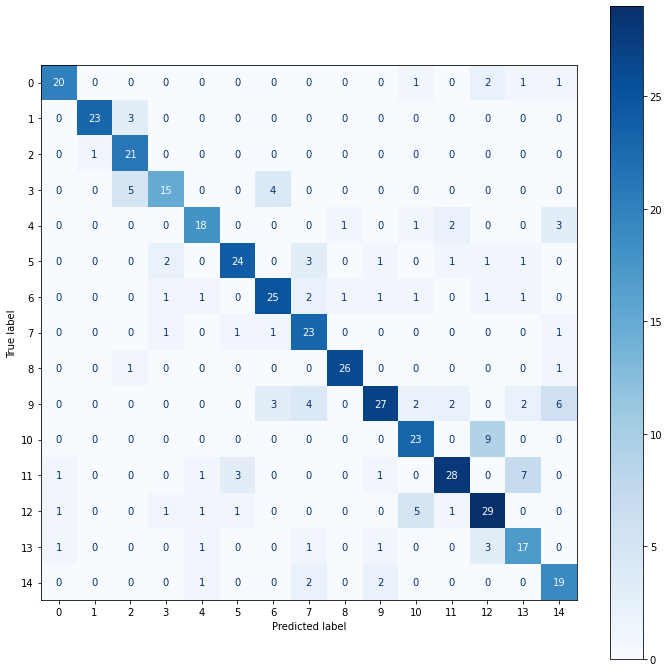

In [22]:
confusion_matrix_display(y_true=np.argmax(y_test, axis=1), # We have to convert the one-hot encoded to single-digit ones 
                         y_pred=y_pred,
                         classes=class_names,
                         figsize=(12, 12),
                         cmap="Blues")